# Part II - (Data Visualization of Loan Dataset from Prosper)
## by (Obi-Okonkwo Chisom)

## Investigation Overview

>The last multivariate plot which is the scatter plot shows that defaulted loans rarely ever have a small interest rate and small loaned amount. The plot also shows that loans of 35% and greater than 30K dollars are raely defaulted because they are given to people with good credit scores.
>Therefore, having a good credit score would almost guarantee the individual a better borrower rate, then the loan would be a low risk loan and the individual would be eligible to a bigger loan if he/she desires.


## Dataset Overview

> The dataset I used was given to me by Udacity. It is a dataset of a lending comapny called Prosper that has over 100,000 loan data observations and many variables that directly or indirectly influence the outcome of each loan.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
loan_data=pd.read_csv('prosperLoanData.csv')

loan_copy=loan_data.copy()
loan_copy=loan_copy[['ListingKey','CreditGrade','Term','LoanStatus','BorrowerRate','ProsperRating (Alpha)',
           'EmploymentStatusDuration','CreditScoreRangeLower','CreditScoreRangeUpper','StatedMonthlyIncome',
            'LoanOriginalAmount','MonthlyLoanPayment']]

In [3]:
# replacing np.nan with an empty string
loan_copy['CreditGrade'].replace(np.nan,'',inplace=True)
loan_copy['ProsperRating (Alpha)'].replace(np.nan,'',inplace=True)

# adding both cols together (one col is pre-2009, the other is after 2009)
loan_copy['Credit_Grade']=loan_copy['CreditGrade']+loan_copy['ProsperRating (Alpha)']
loan_copy['Credit_Grade'].replace('','N/A',inplace=True)

# getting the mean credit score
loan_copy['Credit_Score']=(loan_copy['CreditScoreRangeLower']+loan_copy['CreditScoreRangeUpper'])/2

In [4]:
loan_copy['LoanStatus'].replace('Past Due (1-15 days)','Delinquent',inplace=True)
loan_copy['LoanStatus'].replace('Past Due (16-30 days)','Delinquent',inplace=True)
loan_copy['LoanStatus'].replace('Past Due (31-60 days)','Delinquent',inplace=True)
loan_copy['LoanStatus'].replace('Past Due (61-90 days)','Delinquent',inplace=True)
loan_copy['LoanStatus'].replace('Past Due (91-120 days)','Delinquent',inplace=True)

loan_copy['LoanStatus'].replace('Past Due (>120 days)','Defaulted',inplace=True)

In [5]:
# dropping irrelvant columns
loan_copy.drop(['CreditGrade','ProsperRating (Alpha)','CreditScoreRangeLower','CreditScoreRangeUpper'],axis=1,inplace=True)

# removing observations with empty values for employment duration, current deliquencies and Credit_Grade
loan_copy=loan_copy.dropna(subset=['EmploymentStatusDuration','Credit_Grade'])

# removing rows without a Credit Grade
loan_copy=loan_copy[loan_copy.Credit_Grade!='N/A']

In [6]:
# convert Credit_Grade, Term and LoanStatus into ordered categorical types
ordinal_var_dict = {'Credit_Grade': ['AA','A','B','C','D','E','HR'],
                    'Term': [12,36,60],
                   'LoanStatus':['Completed','FinalPaymentInProgress','Current','Delinquent','Defaulted','Chargedoff','Cancelled']}

for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered=True,categories=ordinal_var_dict[var])
    loan_copy[var]=loan_copy[var].astype(ordered_var)

In [7]:
loan_copy.reset_index(inplace=True,drop=True)

In [8]:
# making an empty column in the dataframe
loan_copy['basic_loan_status']=''

# The different loan statuses are big jargons to a layman. So I am categorizing them in 3 broad categories
loan_copy.loc[loan_copy['LoanStatus']=='Completed','basic_loan_status']='Completed'
loan_copy.loc[loan_copy['LoanStatus']=='FinalPaymentInProgress','basic_loan_status']='Completed'
loan_copy.loc[loan_copy['LoanStatus']=='Current','basic_loan_status']='Current'
loan_copy.loc[loan_copy['LoanStatus']=='Delinquent','basic_loan_status']='Defaulted'
loan_copy.loc[loan_copy['LoanStatus']=='Defaulted','basic_loan_status']='Completed'
loan_copy.loc[loan_copy['LoanStatus']=='Chargedoff','basic_loan_status']='Defaulted'
loan_copy.loc[loan_copy['LoanStatus']=='Cancelled','basic_loan_status']='Defaulted'

> Note that the above cells have been set as "Skip"-type slides. That means
that when the notebook is rendered as http slides, those cells won't show up.

## (Credit Score vs Loan Status)

The company that gave the data did a decent job in identifying potential defaulters. Moving from left to right, we can see a drop in the median credit score (the people in the process of paying would raise the mean of the Completed category). The defaulters have a lower credit score than on average. The cancelled loan is just one observation so it is not enough to make conclusions from.

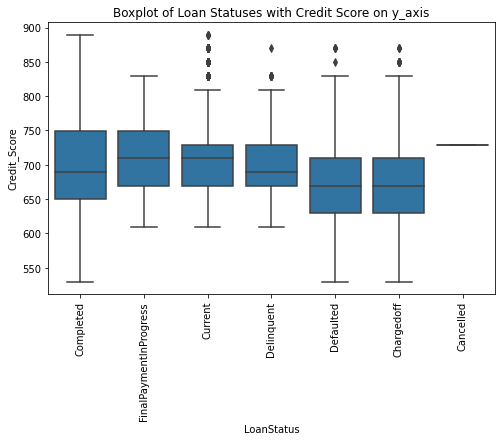

In [9]:
# Loan Status is ordered according to how an investor would prefer
default_color=sb.color_palette()[0]
plt.figure(figsize=[8,5])

sb.boxplot(x=loan_copy['LoanStatus'],y=loan_copy['Credit_Score'],color=default_color)
plt.xticks(rotation=90)
plt.title('Boxplot of Loan Statuses with Credit Score on y_axis')
plt.show()

## (Borrower Rate vs Loan Status)

The plausible explanation for the non-payment by the defaulters(delinquent, defaulted, charged off) is that the interest rate for their loans is higher than the average rate of 0.19. The cancelled category just has one observation so it is treated as an outlier. **The most likely reason is that lenders use the high interest rate to protect themselves when they know the borrower is less likely to pay.**

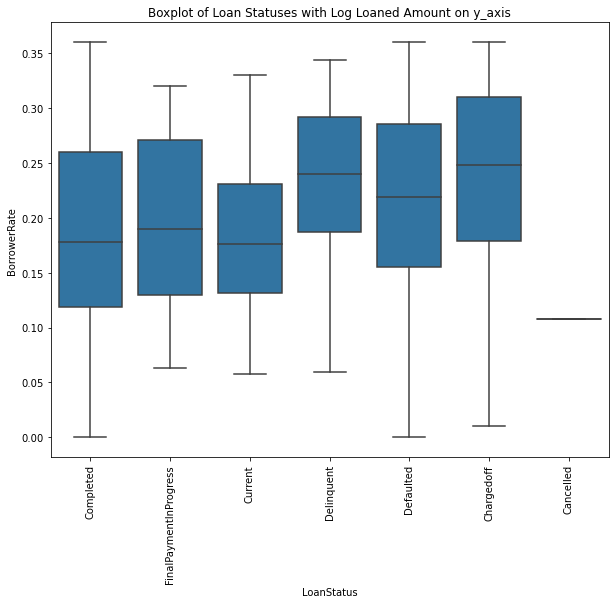

In [10]:
plt.figure(figsize=[10,8])
sb.boxplot(x=loan_copy['LoanStatus'],y=loan_copy['BorrowerRate'],color=default_color)

plt.title('Boxplot of Loan Statuses with Log Loaned Amount on y_axis')
plt.xticks(rotation=90)
plt.show()

## (Relative Frequencies of Loan Status across Loan Grades)

The visualisation is based on the 3 broad categories of a loan; Completed, Current and Defaulted (Delinquent,defaulted,chargedoff). 
<p>Defaulted loans have a steady increase across the levels of credit grade.</p>
<p>What does this mean? It means that the loans level of risk was predicted to a fairly good level.</p>

In [11]:
def fxn(df1,df2):
    cat1_order = ['AA','A','B','C','D','E','HR']
    cat2_order = ['Completed','Current','Defaulted']

    plt.figure(figsize=[10,8])
    artists = [] # for storing references to plot elements
    baselines = np.zeros(len(cat1_order))
    cat1_counts = loan_copy[df1].value_counts()

    # for each second-variable category:
    for i in range(len(cat2_order)):
        # isolate the counts of the first category,
        cat2 = cat2_order[i]
        inner_counts = loan_copy[loan_copy[df2] == cat2][df1].value_counts()
        inner_props = inner_counts / cat1_counts
        # then plot those counts on top of the accumulated baseline
        bars = plt.bar(x = np.arange(len(cat1_order)),
                       height = inner_props[cat1_order],
                       bottom = baselines)
        artists.append(bars)
        baselines += inner_props[cat1_order]

    plt.xticks(np.arange(len(cat1_order)), cat1_order,rotation=90)
    plt.title('Relative Frequencies of Credit Grade in each Loan Status')
    plt.xlabel('Relative Frequency')
    plt.ylabel('Loan Status Categories')
    plt.legend(reversed(artists),reversed(cat2_order),framealpha =1,bbox_to_anchor=(1, 0.5),loc=6,title='Broad Categories of Loan Status')
    plt.show()

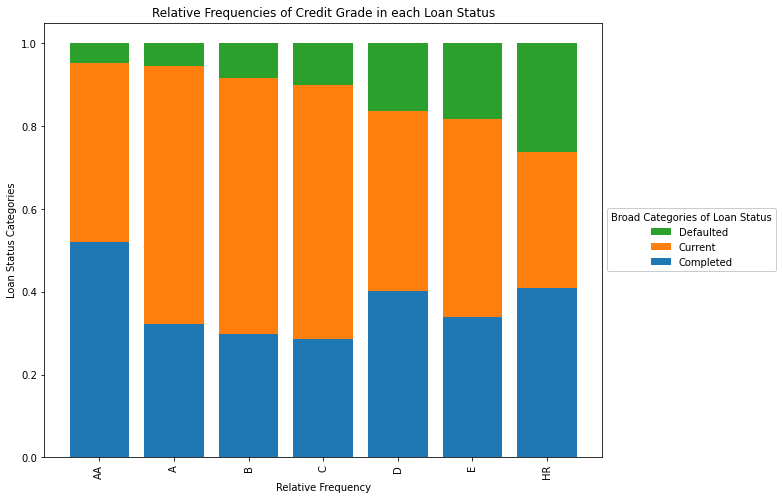

In [12]:
fxn('Credit_Grade','basic_loan_status')

## (Scatter plot of showing comparisons of loan statuses by loaned amount and borrower rate)

<ul>
    <li>The dots seem to be scattered randomly around the plot but upon more observation, we see that the Defaulted loans (orange dots) are more in the upper limits of the plot meaning they usually have higher borrower rates than on average.</li>
    <li>At the left bottom of the plot, only green dots are there meaning that loans with low borrower rate and low loaned amount are generally completed.</li>
    <li>At the top right corner, the density of dots there are low meaning big loans are not given out at high borrower rates.</li>
</ul>

In [13]:
samples=np.random.choice(loan_copy.shape[0],500,replace=False)
loan_samp=loan_copy.loc[samples]

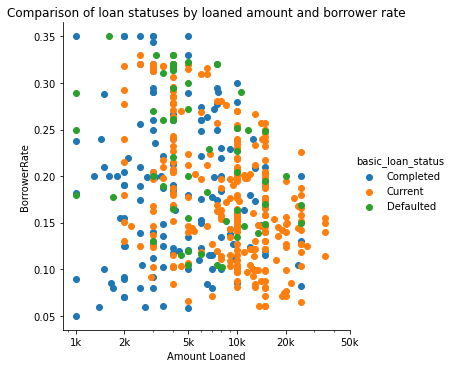

In [14]:
# using a subset of the data to plot

g=sb.FacetGrid(data=loan_samp,hue='basic_loan_status',height=5)
g.map(plt.scatter,'LoanOriginalAmount','BorrowerRate')
g.set(xscale='log')
x_ticks=[1e3,2e3,5e3,10e3,20e3,50e3]
x_labels=['1k','2k','5k','10k','20k','50k']
g.set(xticks=x_ticks,xticklabels=x_labels,title='Comparison of loan statuses by loaned amount and borrower rate')
g.set_xlabels('Amount Loaned')

g.add_legend()
plt.show()

### Generate Slideshow
Once you're ready to generate your slideshow, use the `jupyter nbconvert` command to generate the HTML slide show.  

In [ ]:
# Use this command if you are running this file in local
!jupyter nbconvert Part_II_slide_deck.ipynb --to slides --post serve --no-input --no-prompt